In [62]:
from tensorflow import keras 
import h2o
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [73]:

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
path = "C:\\Users\jmatney\Documents\GitHub\IndianaRisk"
os.chdir(path)

In [3]:
# data
IN_df = pd.read_excel("data\model_data\IN_Risk_Model.xlsx")
IN_df.head()

,subwatershed,circulatory_ratio,relief,avg_slope,elongation_ratio,drainage_density,shape_factor,relief_ratio,ruggedness,aae_area,...,population_density.y,avg_median_income,population_change,dependent_population_pct,dist_to_stream_avg,dist_to_stream_stdev,avg_impervious_percent,orb100yr24ha_am,policy_total_building_coverage_avg,claims_total_building_insurance_coverage_avg
0,51202080201,0.299470,1.010000e+02,11.031308,0.307262,0.412036,9.386736,3.610590e-03,0.050787,0.697929,...,193.107921,58111.000000,1673,41.366667,884.262553,503.506692,0.146502,6789.381348,3212.713978,1180.826665
1,51201110302,0.485784,5.000000e+01,4.080327,0.718304,0.283812,1.484138,4.839883e-03,0.014050,4.034926,...,104.643085,56771.333333,-431,41.466667,1261.467019,535.669076,1.180721,6862.660156,25613.870480,2713.363580
2,51201060507,0.322675,2.600000e+01,2.030253,0.815297,0.647139,1.778003,2.980456e-03,0.017181,2.977041,...,321.678527,48506.750000,-243,41.675000,584.613292,297.702490,1.084871,6175.916504,27111.136390,28374.903350
3,71200010303,0.326203,3.710738e-09,2.053226,0.000588,0.308209,1.027938,4.436303e-13,0.009651,4.357636,...,366.175097,61766.200000,38,42.000000,1087.881755,964.682414,4.389772,5982.229004,33976.722030,43.018237
4,50800030717,0.379072,7.600000e+01,10.546125,0.172761,0.501159,3.978998,4.231477e-03,0.068939,18.411886,...,256.032460,55698.400000,-833,40.660000,555.426454,409.885301,1.661841,5676.336426,63568.611420,9695.319736


In [4]:
IN_mod = IN_df.drop('subwatershed', 1)

In [100]:
# Start local host with given number of threads plus give memory size
h2o.cluster().shutdown()

## Min Max Scaler

In [13]:
###############
## NORMALIZE ##
###############
# IN_norm <- normalizeData(IN_mod, type='0_1')
# colnames(IN_norm) <- names(IN_mod)
# IN_norm_y <- normalizeData(IN_mod$claims_total_building_insurance_coverage_avg, type='0_1')

scaler = MinMaxScaler()
IN_norm = scaler.fit_transform(IN_mod)

In [29]:
IN_norm = pd.DataFrame(IN_norm, columns=IN_mod.columns)

In [31]:
hf = h2o.H2OFrame(IN_norm)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [34]:
train, test, valid = hf.split_frame(ratios=[.8, .15])

In [49]:
predictors = list(IN_mod.loc[:, IN_mod.columns != "claims_total_building_insurance_coverage_avg"].columns)
response = "claims_total_building_insurance_coverage_avg"

## Variable importance plot

In [79]:
def plot_varimp(h2o_model, n_features = None):
    """Plot variable importance for H2O tree-based models"""
    importances = h2o_model.varimp()
    feature_labels = [tup[0] for tup in importances]
    feature_imp = [tup[3] for tup in importances]

    # specify bar centers on the y axis, but flip the order so largest bar appears at top
    pos = range(len(feature_labels))[::-1]
    if n_features is None:
        n_features = min(len(feature_imp), 10)

    fig, ax = plt.subplots(1, 1)
    plt.barh(pos[:n_features], feature_imp[:n_features],
             align = 'center', height = 0.8, color = '#1F77B4', edgecolor = 'none')

    # Hide the right and top spines, color others grey
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('#7B7B7B')
    ax.spines['left'].set_color('#7B7B7B')

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.yticks(pos[:n_features], feature_labels[:n_features])
    plt.ylim([min(pos[:n_features]) - 1, max(pos[:n_features]) + 1])

    title_fontsize = 14
    algo = h2o_model._model_json['algo']
    if algo == 'gbm':
        plt.title('Variable Importance: H2O GBM', fontsize=title_fontsize)
    elif algo == 'drf':
        plt.title('Variable Importance: H2O RF', fontsize=title_fontsize)
    elif algo == 'xgboost':
        plt.title('Variable Importance: H2O XGBoost', fontsize=title_fontsize)

    plt.show()

## Random Forest

In [84]:
# Number of Cross-validation folds
FOLDS = 5

# Build and train the model:
IN_drf = H2ORandomForestEstimator(seed=1111,
                                    ntrees=200,
                                    max_depth=5,
                                    min_rows=10,
                                    nfolds=FOLDS,
                                    keep_cross_validation_predictions=True,
                                    keep_cross_validation_fold_assignment=True)
IN_drf.train(x=predictors,
               y=response,
               training_frame=train,
               validation_frame=valid)

# Eval performance:
drf_perf = IN_drf.model_performance()

# Generate predictions on a validation set (if necessary):
drf_pred = IN_drf.predict(test)

drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [85]:
drf_history = IN_drf.scoring_history()

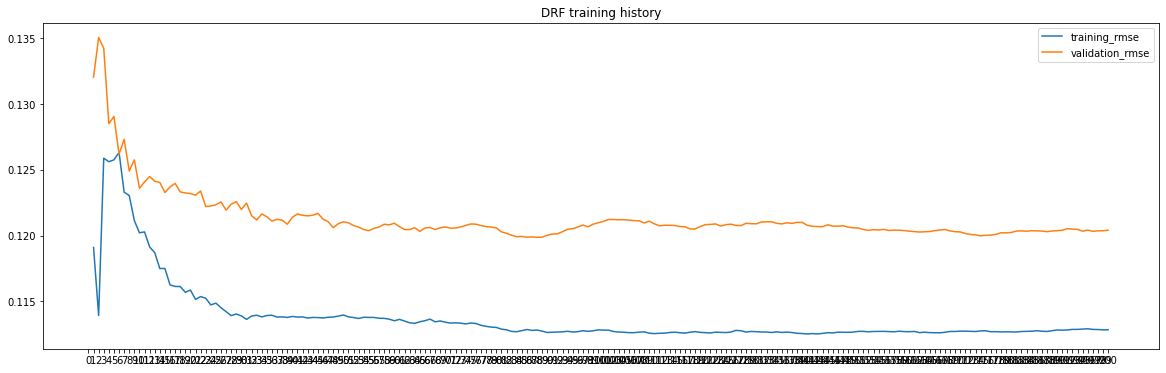

In [93]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 20, 6
plt.rcParams['font.size'] = 10

plt.plot(drf_history['training_rmse'], label = 'training_rmse')
plt.plot(drf_history['validation_rmse'], label = 'validation_rmse')
plt.xticks(range(drf_history.shape[0]), drf_history['number_of_trees'].apply(int))
plt.title('DRF training history')
plt.legend()
plt.show()

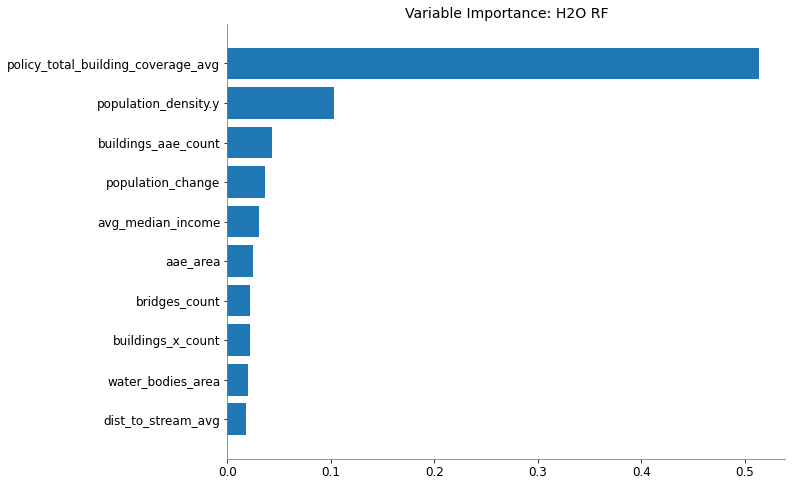

In [87]:
plt.rcParams['figure.figsize'] = 10, 8

plot_varimp(IN_drf)

## Gradient Boosting

In [61]:
# Build and train the model:
IN_gbm = H2OGradientBoostingEstimator(nfolds=FOLDS,
                                        seed=1111,
                                        keep_cross_validation_predictions = True)

IN_gbm.train(x=predictors, 
             y=response, 
             training_frame=train,
             validation_frame=valid)

# Eval performance:
gbm_perf = IN_gbm.model_performance()

# Generate predictions on a test set (if necessary):
gbm_pred = IN_gbm.predict(test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [77]:
gbm_history = IN_gbm.scoring_history()

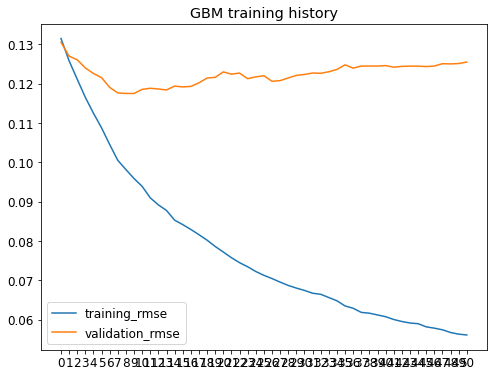

In [76]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.plot(gbm_history['training_rmse'], label = 'training_rmse')
plt.plot(gbm_history['validation_rmse'], label = 'validation_rmse')
plt.xticks(range(gbm_history.shape[0]), gbm_history['number_of_trees'].apply(int))
plt.title('GBM training history')
plt.legend()
plt.show()

In [78]:
IN_gbm.varimp(use_pandas = True).head()

,variable,relative_importance,scaled_importance,percentage
0,policy_total_building_coverage_avg,18.882854,1.000000,0.427719
1,population_density.y,2.963467,0.156940,0.067126
2,orb100yr24ha_am,2.447683,0.129625,0.055443
3,aae_area,1.910220,0.101162,0.043269
4,circulatory_ratio,1.710816,0.090602,0.038752


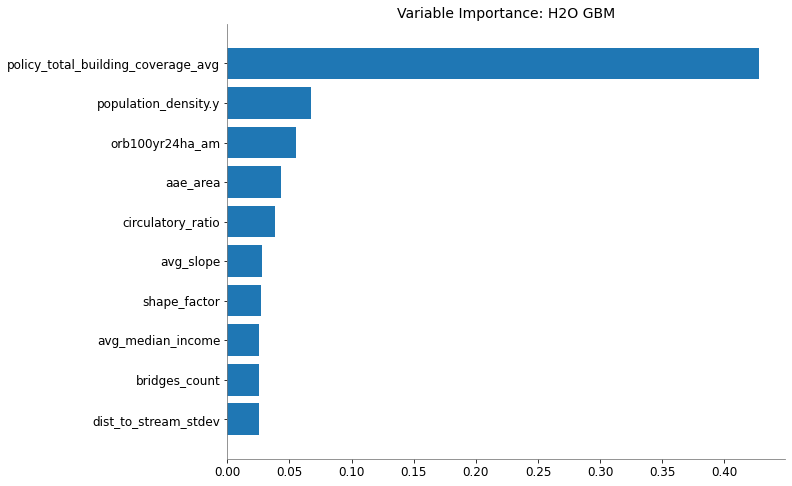

In [80]:
plt.rcParams['figure.figsize'] = 10, 8

plot_varimp(IN_gbm)

## Generalized Linear Model

In [63]:
IN_glm = H2OGeneralizedLinearEstimator(family= "gaussian",
                                          lambda_ = 0,
                                          compute_p_values = True)

IN_glm.train(x=predictors, 
             y=response, 
             training_frame = train,
             validation_frame = valid)

# Eval performance:
glm_perf = IN_glm.model_performance()

# Generate predictions on a test set (if necessary):
glm_pred = IN_glm.predict(test)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [68]:
IN_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1592780320798_6


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,None,25,25,1,py_7_sid_9bbc




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.012566493314855688
RMSE: 0.11210037160890989
MAE: 0.07509790496294215
RMSLE: 0.0910610766507804
R^2: 0.27327435130427435
Mean Residual Deviance: 0.012566493314855688
Null degrees of freedom: 592
Residual degrees of freedom: 567
Null deviance: 10.254117972970455
Residual deviance: 7.451930535709423
AIC: -858.5346114633487

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.014594079441660896
RMSE: 0.12080595780697613
MAE: 0.08969770529771115
RMSLE: 0.10071753092571355
R^2: 0.14307169920241725
Mean Residual Deviance: 0.014594079441660896
Null degrees of freedom: 34
Residual degrees of freedom: 9
Null deviance: 0.5964399074085575
Residual deviance: 0.5107927804581314
AIC: 5.375820067087666

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2020-06-21 20:16:41,0.000 sec,0,10.254118,0.017292


In [94]:
glm_history = IN_glm.scoring_history()

In [96]:
glm_history

,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2020-06-21 20:16:41,0.000 sec,0,10.254118,0.017292


## AutoML

In [56]:
from h2o.automl import H2OAutoML
autoML = H2OAutoML(max_runtime_secs=120)
autoML.train(x=predictors,
             y=response,
             training_frame=train)

AutoML progress: |
19:38:15.358: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [57]:
leaderboard = autoML.leaderboard
print(leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid__1_AutoML_20200621_193815_model_5,0.0128276,0.113259,0.0128276,0.0743332,0.0915211
GBM_grid__1_AutoML_20200621_193815_model_6,0.0130821,0.114377,0.0130821,0.0772424,0.0930025
GBM_2_AutoML_20200621_193815,0.0131141,0.114517,0.0131141,0.0780557,0.0936284
GBM_grid__1_AutoML_20200621_193815_model_2,0.0132112,0.11494,0.0132112,0.0783804,0.0930646
GBM_4_AutoML_20200621_193815,0.0133106,0.115371,0.0133106,0.0776765,0.093848
GBM_5_AutoML_20200621_193815,0.013336,0.115482,0.013336,0.0785215,0.0935434
GBM_grid__1_AutoML_20200621_193815_model_3,0.013357,0.115573,0.013357,0.0774808,0.0936881
GBM_grid__1_AutoML_20200621_193815_model_1,0.0134339,0.115905,0.0134339,0.0789721,0.0936562
StackedEnsemble_BestOfFamily_AutoML_20200621_193815,0.0134581,0.116009,0.0134581,0.0761897,0.0938142
XRT_1_AutoML_20200621_193815,0.013499,0.116185,0.013499,0.0791196,0.0942873


In [65]:
glm_perf


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.012566493314855688
RMSE: 0.11210037160890989
MAE: 0.07509790496294215
RMSLE: 0.0910610766507804
R^2: 0.27327435130427435
Mean Residual Deviance: 0.012566493314855688
Null degrees of freedom: 592
Residual degrees of freedom: 567
Null deviance: 10.254117972970455
Residual deviance: 7.451930535709423
AIC: -858.5346114633487


In [66]:
gbm_perf


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.003146786619005391
RMSE: 0.05609622642393507
MAE: 0.03887729965921695
RMSLE: 0.04555305434391171
Mean Residual Deviance: 0.003146786619005391


In [67]:
drf_perf


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.014452957891926303
RMSE: 0.12022045538063106
MAE: 0.0810609890742535
RMSLE: 0.09738695120531636
Mean Residual Deviance: 0.014452957891926303


## Stacked Ensemble